In [1]:
import torch
from model import load_resnet_model, register_model_with_hook
from utils import sorted_file_paths
from dataloader import create_dataloader, create_dataset
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np

In [93]:
model = load_resnet_model('resnet50', num_classes=1)
statedict = torch.load('./ex_5/checkpoint_epoch_22.pth')
model.load_state_dict(statedict)
model.eval()
get_feature_maps = register_model_with_hook(model)
fc_weights = model.fc.weight.data

In [84]:
# model = load_resnet_model('resnet50', num_classes=1)
# statedict = torch.load('./ex_1/checkpoint_epoch_25.pth')
# model.load_state_dict(statedict)
# model.eval()
# get_feature_maps = register_model_with_hook(model)
# fc_weights = model.fc.weight.data

In [2]:
test_files = sorted_file_paths('./data/records_location/test')
test_dataset = create_dataset(test_files, True, half= False)
test_loader = create_dataloader(test_dataset, 64)

In [3]:
data,location, label = next(iter(test_loader))

In [4]:
input_tensor = data[3:4:,:,:,:]
print(label[3:4])

tensor([2.5860])


In [25]:
def calculate_G_upsample(feature_map, fc_weights, size=(224, 224)):
    # Assuming feature_map is obtained from get_feature_maps function
    # and fc_weights is the weights from the final fully connected layer of the model
    with torch.no_grad():
        weights_reshaped = fc_weights.reshape(-1, 1, 1)
        weighted_feature_maps = feature_map * weights_reshaped
        G = torch.sum(weighted_feature_maps, dim=1, keepdim=True)
        G_squeezed = G.squeeze()
        G_normalized = (G_squeezed - G_squeezed.min()) / (G_squeezed.max() - G_squeezed.min())
        G_upsampled = F.interpolate(G_normalized.unsqueeze(0).unsqueeze(0), size=size, mode='bilinear', align_corners=False).squeeze()
    return G_upsampled

def min_max(rgb_image):
    return rgb_image.min(), rgb_image.max()

def image_from_tensor(input_tensor, quarter):
    end_channel = 3*quarter # e.g. 1 => 3, 2 => 6
    begin_channel = end_channel-3
    return input_tensor[0, begin_channel:end_channel, :, :]

def generate_heatmap(image_tensor, max, min, heatmap, alpha=0.4, brightness_factor=1.0):
    # Check the number of channels in the image tensor
    num_channels = image_tensor.size(0)
    
    # Normalize the image tensor to [0, 1]
    normalized_image = (image_tensor - min) / (max - min)
    
    # Convert to numpy array for visualization
    image_np = normalized_image.cpu().numpy().transpose(1, 2, 0)
    
    # If the image has 1 channel, replicate it to 3 channels for a grayscale effect
    if num_channels == 1:
        image_np = np.repeat(image_np, 3, axis=2)
    
    # Brighten the image if needed
    if brightness_factor != 1.0:
        image_np = np.clip(image_np * brightness_factor, 0, 1)

    # Convert the heatmap to an RGBA image
    heatmap_rgba = plt.cm.jet(heatmap.cpu().numpy())  # Apply colormap

    # Display the image with the heatmap overlay
    fig, ax = plt.subplots()
    ax.imshow(image_np, cmap='gray' if num_channels == 1 else None)
    ax.imshow(heatmap_rgba, alpha=alpha)  # Set the transparency
    ax.axis('off')  # Hide axes
    plt.show()

def meaningful_perturbation(input_tensor, heatmap, num_perturbations=40, neighborhood_size=10):
    # Convert heatmap to numpy if it's a tensor
    if isinstance(heatmap, torch.Tensor):
        heatmap_np = heatmap.cpu().detach().numpy()
    else:
        heatmap_np = heatmap

    # Flatten the heatmap and sort it to identify the most sensitive regions
    flat_heatmap = heatmap_np.flatten()
    sorted_indices = np.argsort(flat_heatmap)[::-1]  # Sort in descending order

    # Copy the input_tensor to perturb
    if isinstance(input_tensor, torch.Tensor):
        perturbed_tensor = input_tensor.clone().detach()
    else:
        perturbed_tensor = input_tensor.copy()

    # Replace the pixels in the sorted order with random noise
    for idx in range(num_perturbations):
        # Convert flat index to 2D index
        row, col = np.unravel_index(sorted_indices[idx], heatmap_np.shape)
        
        # Define the square region to perturb
        row_start = np.clip(row - neighborhood_size // 2, 0, heatmap_np.shape[0])
        col_start = np.clip(col - neighborhood_size // 2, 0, heatmap_np.shape[1])
        row_end = np.clip(row_start + neighborhood_size, 0, heatmap_np.shape[0])
        col_end = np.clip(col_start + neighborhood_size, 0, heatmap_np.shape[1])

        # Generate random noise within [0, 1]
        noise = np.random.uniform(0, 1, (perturbed_tensor.shape[1], neighborhood_size, neighborhood_size))

        # Apply the noise to the neighborhood region across all channels
        perturbed_tensor[:, :, row_start:row_end, col_start:col_end] = \
            torch.from_numpy(noise[:, :row_end-row_start, :col_end-col_start])

    return perturbed_tensor

In [31]:
image.unsqueeze(dim=0).shape

torch.Size([1, 224, 224])

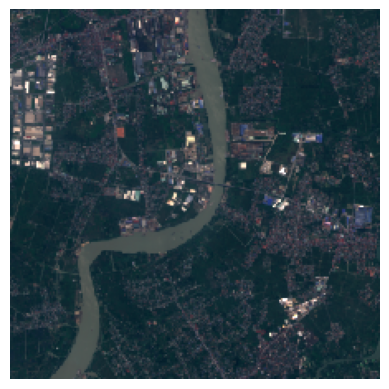

In [45]:
G_zero = torch.zeros((224,224))
# image = input_tensor[0,23,:,:].unsqueeze(dim=0)
image = image_from_tensor(input_tensor, 4)
min, max = min_max(image)
generate_heatmap(image, max, min, G_zero, alpha=0, brightness_factor=5)

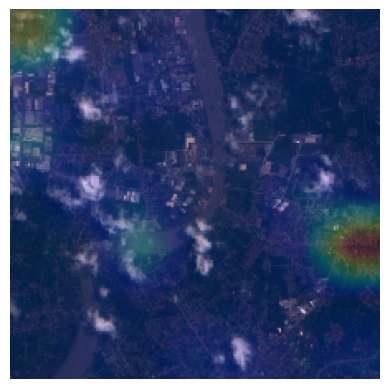

tensor([[2.8117]])


In [95]:
with torch.no_grad():
    feature_map = get_feature_maps(input_tensor)
    output = model(input_tensor)

G_upsampled = calculate_G_upsample(feature_map, fc_weights)
image = image_from_tensor(input_tensor, quarter= 2)
min, max = min_max(image)
print(output)

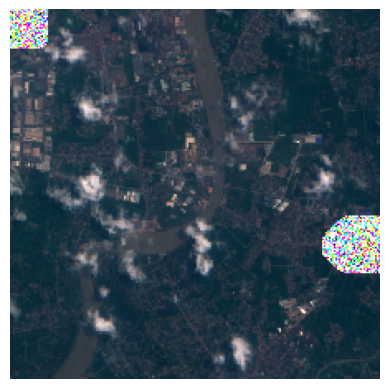

tensor([[2.4460]])


In [97]:
perturbed_tensor = meaningful_perturbation(input_tensor, G_upsampled, num_perturbations=1000, neighborhood_size=10)
perturbed_image = image_from_tensor(perturbed_tensor, quarter=2)
G_perturbed = calculate_G_upsample(feature_map, fc_weights)
generate_heatmap(perturbed_image, max, min, G_perturbed, alpha=0, brightness_factor=3)

with torch.no_grad():
    print(model(perturbed_tensor))